# Domain keywords - feature set


1. load the test set
2. Extract the features from the abstract text
3. Hyperparameter tuning 
    1. Generate the initial training split
    2. Classical 
        - Support Vector machine (SVM)
        - Logistic Regression (LR)
        - Random Forest (RF)
    3. Shallow deep learning models
        - Tuned using optuna
4. Model evaluation
    1. Classical
    2. Shallow deep learning models
        - Priorly tuned model
        - Optuna hyperparameter set

# 0.5 Imports and Functions

In [20]:
# imports

# general
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.random import seed
import re

# sklearn
from sklearn.metrics import classification_report, accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, f1_score, make_scorer, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import svm, tree
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn import model_selection
from sklearn.utils import shuffle


# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import tensorflow_addons as tfa
from keras import backend as K

# optimizing models
import optuna
# visualizing optuna loss
from optuna.visualization import plot_optimization_history

# plotting AUC curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

# scikeras
from scikeras.wrappers import KerasClassifier

# stats
from scipy.stats import sem

# saving
import joblib

In [5]:
def mcc_metric2(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / K.sqrt(den + K.epsilon())

"""
def extract_hyper_results(df, param1, param2):
    
    slice1 = df.loc[( param1, param2),:]
    #slice2 = df.loc[('set2',   param1, param2),:]
    #slice3 = df.loc[('set3',   param1, param2),:]
    #slice4 = df.loc[('set4',   param1, param2),:]
    #slice5 = df.loc[('set5',   param1, param2),:]

    return pd.DataFrame(data=[slice1, slice2, slice3, slice4, slice5]).round(decimals=3)
"""

def extract_hyper_results(df, param1, param2):
    # this method to retrive results are not that good
    slice1 = df.loc[( param1, param2),:]
    #slice2 = df.loc[('set2',   param1, param2),:]
    #slice3 = df.loc[('set3',   param1, param2),:]
    #slice4 = df.loc[('set4',   param1, param2),:]
    #slice5 = df.loc[('set5',   param1, param2),:]

    return pd.DataFrame(data=[slice1]).round(decimals=3)


def scale_mcc(mcc):
    return ((mcc-(-1))/(1-(-1)))*(1-0)+0


def average_loss(cv_results):

    loss_list = []; val_loss_list = []

    for i in cv_results['estimator']:

        loss_list.append(i.history_['loss'])
        val_loss_list.append(i.history_['val_loss'])

    loss_array = np.array(loss_list); val_loss_array = np.array(val_loss_list)
    average_loss = loss_array.mean(axis=0); average_val_loss = val_loss_array.mean(axis=0)

    plt.plot(average_loss); plt.plot(average_val_loss)
    plt.ylim([0.1, 1.5])
    plt.show()

def mcc_metric(y_true, y_pred):
    # 
    predicted = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    true_pos = tf.math.count_nonzero(predicted * y_true)
    true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
    false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
    false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
    x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
    return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

def ann_metrics(model, features, labels):
    
    y_pred = model.predict(features.astype('float32'), batch_size=1, verbose=0)
    #print(y_pred)
    
    y_pred_bool_manual = []
    
    for i in y_pred:
        if i>0.5:
            y_pred_bool_manual.append(1)
        else:
            y_pred_bool_manual.append(0)
    #print(y_pred_bool_manual)
    target_names = ['Relevant', 'Irrelevant']
    res = classification_report(labels, y_pred_bool_manual, output_dict=True)
    
    print(classification_report(labels, y_pred_bool_manual, zero_division=1))
    
    acc = res['accuracy']
    recall = res['1']['recall']
    precision = res['1']['precision']
    f1 = res['1']['f1-score']
    f1_neg = res['0']['f1-score']
    
    
    result = [acc, recall, precision, f1, f1_neg]    
    
    #print(result)
    return result

def run_exps(X_train, y_train , X_test , y_test, X, y):
    
    '''
    Lightweight script to test many models and find winners:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          #('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
         

        ]
    results = []
    names = []
    #scoring = ['accuracy', 'recall', 'precision', 'f1', 'matthews_corrcoef', 'roc_auc']
    
    scoring = {'accuracy': 'accuracy',
           'recall': 'recall',
           'precision': 'precision',
           'mcc': 'matthews_corrcoef',
           'auc': 'roc_auc',
           'f1_pos': 'f1',
           'f1_neg': make_scorer(f1_score, pos_label=0, average='binary')
          }    
    
    target_names = ['Relevant', 'Irrelevant']
    
    result_dict = {}
    
    for name, model in models:
        
        # kfold - repeatedstratifyKFold
        
        #kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
        kfold = model_selection.RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=1)
        
        cv_results = model_selection.cross_validate(model, X, y, cv=kfold, scoring=scoring, return_train_score=True)
        
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        train_pred = clf.predict(X_train)
        print(name)
        res = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

        print('train')
        print(classification_report(y_train, train_pred, target_names=target_names))
        print('MCC', matthews_corrcoef(y_train, train_pred))
        print('AUC', roc_auc_score(y_train, train_pred))
        print('test')
        print(classification_report(y_test, y_pred, target_names=target_names))
        print('MCC', matthews_corrcoef(y_test, y_pred))
        print('AUC', roc_auc_score(y_test, y_pred))
        result_dict[name] = res
        
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
        final = pd.concat(dfs, ignore_index=True)
    
    return final, result_dict

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [relevant]')
    plt.legend()
    plt.grid(True)
    
def get_n_grams(keywords, unique_1_grams = False, n_grams = 3):

    n_gram_list = []
    for i in range(n_grams):
        count = CV(ngram_range=(i+1, i+1))
        n_grams = count.fit_transform(keywords)
        #ng_list = list(count.vocabulary_)
        n_gram_list.append(list(count.vocabulary_))

    if unique_1_grams:
        uniq_1_gram = []
        non_uniq_1_gram = []
        one_gram_list = n_gram_list[0]
        two_gram_str = str(n_gram_list[1])
        three_gram_str = str(n_gram_list[2])

        for one_gram in one_gram_list:

            if re.search(one_gram, two_gram_str):
                non_uniq_1_gram.append(one_gram)

            elif re.search(one_gram, three_gram_str):
                non_uniq_1_gram.append(one_gram)

            else:
                uniq_1_gram.append(one_gram)

        n_gram_list.pop(0)
        n_gram_list.insert(0, non_uniq_1_gram)
        n_gram_list.insert(0, uniq_1_gram)

    return n_gram_list

def flatten(xs):
    # found on stack overflow, directly pasted
    res = []

    def loop(ys):
        for i in ys:
            if isinstance(i, list):
                loop(i)
            else:
                res.append(i)
    loop(xs)
    return res

def plot_auc_curve(x_train, x_test, y_train, y_test, model):

    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)

    fpr_test, tpr_test, thresholds_keras = roc_curve(y_test, y_test_pred)
    fpr_train, tpr_train, thresholds_keras = roc_curve(y_train, y_train_pred)

    auc_test = auc(fpr_test, tpr_test)
    auc_train = auc(fpr_train, tpr_train)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_test, tpr_test, label='train (area = {:.3f})'.format(auc_test))
    plt.plot(fpr_train, tpr_train, label='test (area = {:.3f})'.format(auc_train))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    #plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    

def generate_features(dataframe):
    # used to convert the training/validation splits into the features - frequencies of specified keywords
    freq_df = pd.DataFrame()
    freq_df['label'] = dataframe['label']

    for index, abstract in enumerate(dataframe['abstract']):

        for key in ngrams:

            match_list = re.findall(key, abstract.lower())

            if key not in freq_df:
                freq_df[key] = ''
                freq_df.loc[index, [key]] = len(match_list)

            else:
                freq_df.loc[index, [key]] = len(match_list)
                
    y = freq_df.loc[:, ['label']]
    del freq_df['label'] 
    
    return freq_df, np.array(y).ravel()

def mcc_threshold(threshold):
    def mcc_metric2(y_true, y_pred):
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        tp = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        tn = K.round(K.sum(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        fp = K.round(K.sum(K.clip((1 - y_true) * y_pred, 0, 1)))
        fn = K.round(K.sum(K.clip(y_true * (1 - y_pred), 0, 1)))

        num = tp * tn - fp * fn
        den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
        return num / K.sqrt(den + K.epsilon())
    return mcc_metric2


def custom_f1_pos(y_true, y_pred):
    # need to incorporate custom thresholds as rounding does seem to not take a custom one into account

    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# find what is correct, and change

def custom_f1_neg(y_true, y_pred):
    # do we need to take into account the threshold here?
    # this is not the way, find a better way
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tn / (tn + fn + K.epsilon())
    r = tn / (tn + fp + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 2*((p*r)/(p+r+K.epsilon()))


def calculate_f1_score(y, pred, threshold, pos_label):
    # if this also wrong, I compute myself
    y_pred = pred.copy()

    y_pred[y_pred > threshold] = 1
    y_pred[y_pred < threshold] = 0

    return f1_score(y, y_pred, pos_label=pos_label)

# 1 load the test set

In [6]:
test_set = pd.read_json('data/new_test_set_II.json')
test = pd.read_json('data/validation_set.json')

In [6]:
training1 = pd.read_json('data/new_test_set_II.json')
training2 = pd.read_json('data/validation_set.json')
training1 = training1.rename(columns={'DOI':'doi', 'Abstract': 'abstract', 'Label':'label'})

train = pd.concat([training1, training2]).reset_index(drop=True)

In [50]:
train

,doi,abstract,label
0,10.1016/j.cattod.2019.08.027,© 2019 Elsevier B.V.Sodium titanate nanotubes ...,0
1,10.1016/j.fuel.2021.120653,© 2021 Elsevier LtdThis research investigated ...,1
2,10.1016/j.fuel.2014.07.035,This research reports on the synthesis of meth...,1
3,10.1016/j.enconman.2017.03.044,© 2017 Elsevier LtdAn optimization of methyl e...,1
4,10.1016/j.supflu.2011.11.012,This work reports phase equilibrium measuremen...,1
...,...,...,...
495,10.1016/j.fuproc.2010.05.032,"In this study, biodiesel was produced from Mor...",1
496,10.1016/j.combustflame.2013.09.013,The oxidation characteristics of several small...,0
497,10.1016/j.algal.2015.09.006,The feasibility of microalgae based biodiesel ...,0
498,10.1016/j.biortech.2016.05.020,Mixotrophic growth of microalgae to boost lipi...,0


In [236]:
count = train['abstract'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_values(axis=0, ascending=False)
count.mean()

192.062

# 2 Extract the features from the abstract text

In [7]:
keyword_list = []

with open('data/keywords.txt') as keywords:
    for key in keywords:
        keyword_list.append(key.strip('\n'))

print(keyword_list)
ngrams = flatten(get_n_grams(keyword_list))
print(ngrams)

['transesterification', 'esterification', 'optimisation', 'optimization', 'synthesi', 'catalys', 'biodiesel', 'production', 'rsm', 'wfo', 'wco', 'doe', 'ccd', 'bbd', 'FAME', 'FAEE', 'FAAE', 'FABE', 'FAPE', 'lewis', 'glycerolysis', 'alcoholysis', 'homogeneous catalys', 'heterogeneous catalys', 'enzymatic catalys', 'waste fish oil', 'waste cooking oil', 'box-behnken design', 'response surface methodology', 'waste frying oil', 'waste cooking oil', 'central composite design']
['transesterification', 'esterification', 'optimisation', 'optimization', 'synthesi', 'catalys', 'biodiesel', 'production', 'rsm', 'wfo', 'wco', 'doe', 'ccd', 'bbd', 'fame', 'faee', 'faae', 'fabe', 'fape', 'lewis', 'glycerolysis', 'alcoholysis', 'homogeneous', 'heterogeneous', 'enzymatic', 'waste', 'fish', 'oil', 'cooking', 'box', 'behnken', 'design', 'response', 'surface', 'methodology', 'frying', 'central', 'composite', 'homogeneous catalys', 'heterogeneous catalys', 'enzymatic catalys', 'waste fish', 'fish oil', 'w

In [239]:
freq_df = pd.DataFrame()
freq_df['label'] = train['label']

for index, abstract in enumerate(train['abstract']):

    for key in ngrams:
        
        match_list = re.findall(key, abstract.lower())
        
        if key not in freq_df:
            freq_df[key] = ''
            freq_df.loc[index, [key]] = len(match_list)
            
        else:
            freq_df.loc[index, [key]] = len(match_list)

In [10]:
freq_df.columns

Index(['label', 'transesterification', 'esterification', 'optimisation',
       'optimization', 'synthesi', 'catalys', 'biodiesel', 'production', 'rsm',
       'wfo', 'wco', 'doe', 'ccd', 'bbd', 'fame', 'faee', 'faae', 'fabe',
       'fape', 'lewis', 'glycerolysis', 'alcoholysis', 'homogeneous',
       'heterogeneous', 'enzymatic', 'waste', 'fish', 'oil', 'cooking', 'box',
       'behnken', 'design', 'response', 'surface', 'methodology', 'frying',
       'central', 'composite', 'homogeneous catalys', 'heterogeneous catalys',
       'enzymatic catalys', 'waste fish', 'fish oil', 'waste cooking',
       'cooking oil', 'box behnken', 'behnken design', 'response surface',
       'surface methodology', 'waste frying', 'frying oil',
       'central composite', 'composite design', 'waste fish oil',
       'waste cooking oil', 'box behnken design',
       'response surface methodology', 'waste frying oil',
       'central composite design'],
      dtype='object')

In [9]:
freq_df

,label,transesterification,esterification,optimisation,optimization,synthesi,catalys,biodiesel,production,rsm,...,waste frying,frying oil,central composite,composite design,waste fish oil,waste cooking oil,box behnken design,response surface methodology,waste frying oil,central composite design
0,0,2,2,0,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4,4,0,0,0,1,4,2,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,1,2,1,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,2,1,0,1,...,0,0,1,1,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,1,1,0,0,0,0,12,2,0,...,0,0,0,0,0,0,0,0,0,0
397,1,0,3,0,0,1,4,2,1,0,...,0,0,0,0,0,0,0,0,0,0
398,1,0,0,0,1,0,0,2,1,1,...,0,0,0,0,0,0,0,2,0,0


# 3 Hyperparameter tuning 

## 3.1. Classical

### 3.1.1. SVM

In [12]:
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

svm_dict = {}

    
X, y = generate_features(train)
res_list = []

for c in C:

    for g in gamma:
        res_dict = {'C':float, 'gamma': float, 'metric': {}}
        single_res = {'train_accuracy': float, 'test_accuracy': float, 'train_recall': float, 'test_recall': float, 'train_precison': float,
                        'test_precison': float,'train_auc': float, 'test_auc': float, 'train_f1_pos':float, 'test_f1_pos': float, 'train_f1_neg': float, 'test_f1_neg': float}

        clf = SVC(C=c, gamma=g)

        # RepeatedStratifiedKfold

        kfold = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

        scoring = {'accuracy': 'accuracy',
                    'recall': 'recall',
                    'precison': 'precision',
                    'auc': 'roc_auc',
                    'f1_pos': 'f1',
                    'f1_neg': make_scorer(f1_score, pos_label=0, average='binary')
                    }  

        cv_results = model_selection.cross_validate(clf, X, y, cv=kfold, scoring=scoring, return_train_score=True)

        for metric, values in cv_results.items():
            
            single_res[metric] = (np.round(values.mean(), decimals=3), np.round(values.std(), decimals=3))
            

        
        res_dict['C'] = c
        res_dict['gamma'] = g
        res_dict['metric'] = single_res

        res_list.append(res_dict)

svm_dict['set1'] = res_list

hyper_list = []
data_list = []

for j, res in svm_dict.items():
    
    for i in res:
        
        hyper_list.append((j, i['C'], i['gamma']))

        data_list.append(i['metric'])

index = pd.MultiIndex.from_tuples(hyper_list, names=['train/valset', 'C', 'gamma'])
svm_df = pd.DataFrame(data_list, index=index)

c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classi

In [29]:
svm_df.loc[('set1', 100, 0.001)]

train_accuracy    (0.891, 0.009)
test_accuracy     (0.851, 0.041)
train_recall      (0.876, 0.014)
test_recall       (0.837, 0.048)
train_precison       (0.9, 0.01)
test_precison     (0.859, 0.056)
train_auc         (0.955, 0.004)
test_auc          (0.927, 0.026)
train_f1_pos      (0.888, 0.009)
test_f1_pos       (0.847, 0.042)
train_f1_neg      (0.895, 0.008)
test_f1_neg       (0.855, 0.042)
fit_time           (0.01, 0.001)
score_time          (0.014, 0.0)
Name: (set1, 100.0, 0.001), dtype: object

In [241]:
hyper_list = []
data_list = []

for j, res in svm_dict.items():
    
    for i in res:
        
        hyper_list.append((i['C'], i['gamma']))

        data_list.append(i['metric'])

index = pd.MultiIndex.from_tuples(hyper_list, names=[ 'C', 'gamma'])
svm_df = pd.DataFrame(data_list, index=index)

In [242]:
df_c100g001 = extract_hyper_results(svm_df, 100, 0.001)
df_c100g001

,,train_accuracy,test_accuracy,train_recall,test_recall,train_mcc,test_mcc,train_auc,test_auc,train_f1_pos,test_f1_pos,train_f1_neg,test_f1_neg,fit_time,score_time
100.0,0.001,"(0.891, 0.009)","(0.851, 0.041)","(0.876, 0.014)","(0.837, 0.048)","(0.783, 0.017)","(0.704, 0.082)","(0.955, 0.004)","(0.927, 0.026)","(0.888, 0.009)","(0.847, 0.042)","(0.895, 0.008)","(0.855, 0.042)","(0.026, 0.01)","(0.037, 0.011)"


In [195]:
df_c100g001 = extract_hyper_results(svm_df, 100, 0.001)
df_c100g001

,,train_accuracy,test_accuracy,train_recall,test_recall,train_mcc,test_mcc,train_auc,test_auc,train_f1_pos,test_f1_pos,train_f1_neg,test_f1_neg,fit_time,score_time
100.0,0.001,"(0.891, 0.009)","(0.851, 0.041)","(0.876, 0.014)","(0.837, 0.048)","(0.783, 0.017)","(0.704, 0.082)","(0.955, 0.004)","(0.927, 0.026)","(0.888, 0.009)","(0.847, 0.042)","(0.895, 0.008)","(0.855, 0.042)","(0.011, 0.001)","(0.015, 0.001)"


,,,train_accuracy,test_accuracy,train_recall,test_recall,train_mcc,test_mcc,train_auc,test_auc,train_f1_pos,test_f1_pos,train_f1_neg,test_f1_neg,fit_time,score_time
set1,100.0,0.001,"(0.877, 0.01)","(0.815, 0.037)","(0.862, 0.021)","(0.814, 0.05)","(0.755, 0.02)","(0.633, 0.075)","(0.947, 0.007)","(0.906, 0.029)","(0.875, 0.011)","(0.814, 0.035)","(0.88, 0.01)","(0.815, 0.04)","(0.008, 0.002)","(0.014, 0.002)"
set2,100.0,0.001,"(0.901, 0.009)","(0.875, 0.025)","(0.874, 0.017)","(0.857, 0.052)","(0.802, 0.018)","(0.753, 0.049)","(0.955, 0.006)","(0.935, 0.021)","(0.896, 0.01)","(0.87, 0.027)","(0.905, 0.009)","(0.879, 0.024)","(0.008, 0.002)","(0.015, 0.003)"
set3,100.0,0.001,"(0.89, 0.01)","(0.832, 0.026)","(0.871, 0.02)","(0.823, 0.043)","(0.78, 0.019)","(0.667, 0.053)","(0.954, 0.007)","(0.917, 0.02)","(0.887, 0.011)","(0.83, 0.026)","(0.892, 0.009)","(0.834, 0.028)","(0.007, 0.004)","(0.015, 0.005)"
set4,100.0,0.001,"(0.88, 0.009)","(0.828, 0.029)","(0.844, 0.018)","(0.794, 0.047)","(0.759, 0.019)","(0.656, 0.058)","(0.949, 0.007)","(0.915, 0.026)","(0.868, 0.011)","(0.812, 0.031)","(0.889, 0.008)","(0.84, 0.029)","(0.008, 0.003)","(0.014, 0.003)"
set5,100.0,0.001,"(0.92, 0.008)","(0.872, 0.026)","(0.928, 0.014)","(0.882, 0.04)","(0.84, 0.017)","(0.744, 0.051)","(0.978, 0.003)","(0.95, 0.016)","(0.92, 0.008)","(0.872, 0.026)","(0.92, 0.009)","(0.871, 0.026)","(0.009, 0.003)","(0.015, 0.002)"


### 3.1.2. LR

In [30]:
C = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga']

lr_dict = {}

X, y = generate_features(train)
res_list = []

for c in C:
    
    for solver in solvers:
        
        res_dict = {'C':float, 'solver': str, 'metric': {}}
        single_res = {'train_accuracy': float, 'test_accuracy': float, 'train_recall': float, 'test_recall': float, 'train_precison': float,
                        'test_precison': float,'train_auc': float, 'test_auc': float, 'train_f1_pos':float, 'test_f1_pos': float, 'train_f1_neg': float, 'test_f1_neg': float}

        clf = LogisticRegression(C=c, solver=solver, max_iter=300)

        # RepeatedStratifiedKfold

        kfold = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

        scoring = {'accuracy': 'accuracy',
                    'recall': 'recall',
                    'precison': 'precision',
                    'auc': 'roc_auc',
                    'f1_pos': 'f1',
                    'f1_neg': make_scorer(f1_score, pos_label=0, average='binary')
                    }   

        cv_results = model_selection.cross_validate(clf, X, y, cv=kfold, scoring=scoring, return_train_score=True)

        for metric, values in cv_results.items():
            single_res[metric] = (np.round(values.mean(), decimals=3), np.round(values.std(), decimals=3))


        res_dict['C'] = c
        res_dict['solver'] = solver
        res_dict['metric'] = single_res

        res_list.append(res_dict)

lr_dict['set1'] = res_list

c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\NMBU\Miniconda3\envs\trying_stuff3\lib\site-packages\sklearn\metrics\_classi

In [31]:
hyper_list = []
data_list = []

for j, res in lr_dict.items():
    
    for i in res:
        
        hyper_list.append((i['C'], i['solver']))

        data_list.append(i['metric'])
        
index = pd.MultiIndex.from_tuples(hyper_list, names=['C', 'solver'])
lr_df = pd.DataFrame(data_list, index=index)

In [32]:
extract_hyper_results(lr_df, 1e-1, 'lbfgs')

,,train_accuracy,test_accuracy,train_recall,test_recall,train_precison,test_precison,train_auc,test_auc,train_f1_pos,test_f1_pos,train_f1_neg,test_f1_neg,fit_time,score_time
0.1,lbfgs,"(0.855, 0.011)","(0.825, 0.035)","(0.834, 0.012)","(0.811, 0.049)","(0.865, 0.013)","(0.832, 0.048)","(0.928, 0.006)","(0.911, 0.025)","(0.849, 0.012)","(0.82, 0.036)","(0.86, 0.011)","(0.83, 0.036)","(0.016, 0.003)","(0.017, 0.003)"


In [ ]:
extract_hyper_results(lr_df, 1e-1, 'lbfgs')

,,,train_accuracy,test_accuracy,train_recall,test_recall,train_mcc,test_mcc,train_auc,test_auc,train_f1_pos,test_f1_pos,train_f1_neg,test_f1_neg,fit_time,score_time
set1,0.1,lbfgs,"(0.829, 0.013)","(0.802, 0.037)","(0.808, 0.016)","(0.784, 0.051)","(0.658, 0.027)","(0.607, 0.074)","(0.913, 0.01)","(0.889, 0.033)","(0.824, 0.014)","(0.798, 0.036)","(0.833, 0.013)","(0.805, 0.04)","(0.016, 0.007)","(0.013, 0.006)"
set2,0.1,lbfgs,"(0.875, 0.012)","(0.856, 0.027)","(0.85, 0.015)","(0.84, 0.051)","(0.751, 0.025)","(0.713, 0.055)","(0.938, 0.007)","(0.924, 0.022)","(0.87, 0.013)","(0.85, 0.03)","(0.88, 0.012)","(0.86, 0.027)","(0.011, 0.008)","(0.014, 0.008)"
set3,0.1,lbfgs,"(0.852, 0.015)","(0.825, 0.03)","(0.828, 0.019)","(0.811, 0.052)","(0.706, 0.03)","(0.651, 0.061)","(0.923, 0.009)","(0.905, 0.028)","(0.848, 0.016)","(0.821, 0.032)","(0.857, 0.014)","(0.827, 0.03)","(0.012, 0.002)","(0.013, 0.003)"
set4,0.1,lbfgs,"(0.847, 0.012)","(0.806, 0.035)","(0.81, 0.019)","(0.769, 0.053)","(0.694, 0.024)","(0.611, 0.072)","(0.918, 0.007)","(0.895, 0.027)","(0.833, 0.013)","(0.788, 0.04)","(0.86, 0.011)","(0.82, 0.033)","(0.012, 0.003)","(0.013, 0.003)"
set5,0.1,lbfgs,"(0.876, 0.009)","(0.85, 0.027)","(0.869, 0.012)","(0.844, 0.051)","(0.753, 0.017)","(0.702, 0.053)","(0.953, 0.003)","(0.936, 0.015)","(0.874, 0.009)","(0.847, 0.03)","(0.879, 0.008)","(0.852, 0.027)","(0.013, 0.003)","(0.014, 0.003)"


### 3.1.3. RF

In [34]:
N = [1,2,3,4,5,6,7,8,9] + [100] + [1000] + [10000] 
criterions = ['gini', 'entropy', 'log_loss']

rf_dict = {}

    
X, y = generate_features(train)
res_list = []

for n in N:
    
    for crit in criterions:
        
        res_dict = {'C':float, 'criterion': str, 'metric': {}}
        single_res = {'train_accuracy': float, 'test_accuracy': float, 'train_recall': float, 'test_recall': float, 'train_precison': float,
                        'test_precison': float,'train_auc': float, 'test_auc': float, 'train_f1_pos':float, 'test_f1_pos': float, 'train_f1_neg': float, 'test_f1_neg': float}


        clf = RandomForestClassifier(n_estimators=n, criterion=crit)

        # RepeatedStratifiedKfold

        kfold = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

        scoring = {'accuracy': 'accuracy',
                    'recall': 'recall',
                    'precison': 'precision',
                    'auc': 'roc_auc',
                    'f1_pos': 'f1',
                    'f1_neg': make_scorer(f1_score, pos_label=0, average='binary')
                    }  

        cv_results = model_selection.cross_validate(clf, X, y, cv=kfold, scoring=scoring, return_train_score=True)

        for metric, values in cv_results.items():
            single_res[metric] = (np.round(values.mean(), decimals=3), np.round(values.std(), decimals=3))


        res_dict['N'] = n
        res_dict['criterion'] = crit
        res_dict['metric'] = single_res

        res_list.append(res_dict)

rf_dict['set1'] = res_list

In [36]:
hyper_list = []
data_list = []

for j, res in rf_dict.items():
    
    for i in res:
        
        hyper_list.append((i['N'], i['criterion']))

        data_list.append(i['metric'])

index = pd.MultiIndex.from_tuples(hyper_list, names=['n-estimators', 'solver'])
rf_df = pd.DataFrame(data_list, index=index)

In [40]:
rf_df.loc[(10000, 'entropy')]

train_accuracy      (0.99, 0.002)
test_accuracy      (0.854, 0.033)
train_recall        (0.98, 0.004)
test_recall        (0.876, 0.041)
train_precison         (1.0, 0.0)
test_precison      (0.836, 0.045)
train_auc          (0.995, 0.001)
test_auc           (0.925, 0.021)
train_f1_pos        (0.99, 0.002)
test_f1_pos        (0.854, 0.032)
train_f1_neg        (0.99, 0.002)
test_f1_neg        (0.852, 0.035)
fit_time          (20.568, 0.568)
score_time         (2.405, 0.175)
Name: (10000, entropy), dtype: object

In [221]:
extract_hyper_results(rf_df, 10000, 'entropy')

,,train_accuracy,test_accuracy,train_recall,test_recall,train_mcc,test_mcc,train_auc,test_auc,train_f1_pos,test_f1_pos,train_f1_neg,test_f1_neg,fit_time,score_time
10000,entropy,"(0.99, 0.002)","(0.854, 0.032)","(0.98, 0.004)","(0.878, 0.041)","(0.98, 0.004)","(0.712, 0.064)","(0.995, 0.001)","(0.925, 0.021)","(0.99, 0.002)","(0.855, 0.031)","(0.99, 0.002)","(0.853, 0.034)","(20.827, 1.095)","(2.423, 0.379)"


## 3.3. Shallow neural net


### 3.3.1 Tuning with optuna

In [10]:
five_fold = []

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=1)

freq = get_features(train)

for train_index, test_index in kf.split(freq):
    t = freq.loc[train_index, :]
    v = freq.loc[test_index, :]

    five_fold.append((t,v))

In [9]:
def get_features(dataframe):
    # function similar to generate features, here we don't split out the label, as the train/test split is done below.

    freq_df = pd.DataFrame()
    freq_df['label'] = dataframe['label']

    for index, abstract in enumerate(dataframe['abstract']):

        for key in ngrams:

            match_list = re.findall(key, abstract.lower())

            if key not in freq_df:
                freq_df[key] = ''
                freq_df.loc[index, [key]] = len(match_list)

            else:
                freq_df.loc[index, [key]] = len(match_list)
                
    #y = freq_df.loc[:, ['label']]
    #del freq_df['label'] 
    
    return freq_df

In [13]:
def create_ann_model(trial):
    
    n_hidden = trial.suggest_int('n_hidden', 1, 12)
    n_units = trial.suggest_int('n_units', 1, 100)
    
    #hidden_activation = trial.suggest_categorical('activation', ['elu', 'relu'])
    k_regularizer = trial.suggest_float('kernel_regularizer', 1e-5, 1e-1)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    
    dropout = trial.suggest_float('dropout', 0.2, 0.8)
    
    threshold = trial.suggest_float('pred_threshold', 0.2, 0.8)
    #threshold=0.5
    
    
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape = (59,)))

    for i in range(n_hidden - 1):
        
        model.add(keras.layers.Dense(n_units, activation='relu', kernel_regularizer=regularizers.L1(k_regularizer)))
    model.add(keras.layers.Dropout(dropout))

    model.add(keras.layers.Dense(1, activation='sigmoid'))
        
                             
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False
                                                   ),
                 optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
                 metrics=['AUC', keras.metrics.BinaryAccuracy(threshold=threshold),
                                 keras.metrics.Recall(thresholds=threshold),
                                 keras.metrics.Precision(thresholds=threshold)])
    
    return model
    
    
def objective(trial):

    loss_list = []; auc_list = []; acc_list = []; rec_list = []; prec_list = [];f1_list=[]


    for t, v in five_fold:
        #[(train, val), (train, val)]

        y = t['label'].values; X = t.drop(columns=['label']).astype('float64')
        y_test = v['label'].values; X_test = v.drop(columns=['label']).astype('float64')

        #y = t['label'].values; X = t.drop(columns=['label']).astype('float64')
        #y_test = v['label'].values; X_test = v.drop(columns=['label']).astype('float64')
    
        model = create_ann_model(trial)
        
        model.fit(X.astype('float64'), y, validation_split=0.25, verbose=0, epochs=100, batch_size=100)
        
        score = model.evaluate(X_test.astype('float64'), y_test, verbose=0)

        loss_list.append(score[0])
        auc_list.append(score[1])
        acc_list.append(score[2])
        rec_list.append(score[3])
        prec_list.append(score[4])
        y_pred = model.predict(X_test, verbose=0)

        f1_list.append(calculate_f1_score(y_test, y_pred, threshold=.5, pos_label=1))
    
    return np.array(acc_list).mean(), np.array(rec_list).mean(), np.array(f1_list).mean(), np.array(prec_list).mean()


study = optuna.create_study(study_name='keyw_freq_features', directions=['maximize', 'maximize', 'maximize', 'maximize'], sampler=optuna.samplers.NSGAIISampler(), pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=500, n_jobs=1)

[I 2023-09-10 14:12:30,007] A new study created in memory with name: keyw_freq_features


[I 2023-09-10 14:13:48,177] Trial 0 finished with values: [0.5099999964237213, 0.0, 0.11830985915492957, 0.0] and parameters: {'n_hidden': 5, 'n_units': 78, 'kernel_regularizer': 0.04570330995792679, 'learning_rate': 0.007543190553420588, 'dropout': 0.24140384453938152, 'pred_threshold': 0.7846052491863149}. 
[I 2023-09-10 14:15:15,345] Trial 1 finished with values: [0.5099999964237213, 0.0, 0.11830985915492957, 0.0] and parameters: {'n_hidden': 8, 'n_units': 70, 'kernel_regularizer': 0.04472502357905954, 'learning_rate': 0.014327335273360999, 'dropout': 0.7326154079045972, 'pred_threshold': 0.6188577994757773}. 
[I 2023-09-10 14:16:10,710] Trial 2 finished with values: [0.7560000061988831, 0.6508156418800354, 0.7780823773927222, 0.8236770987510681] and parameters: {'n_hidden': 1, 'n_units': 4, 'kernel_regularizer': 0.013222496929380125, 'learning_rate': 0.08527858635436371, 'dropout': 0.6462592766012643, 'pred_threshold': 0.6369088746772722}. 
[I 2023-09-10 14:17:29,728] Trial 3 finis

In [14]:
len(study.best_trials)

56

In [19]:
pure_df = study.trials_dataframe()
pure_df = pure_df.rename(columns=({'values_0': 'accuracy', 'values_1': 'recall', 'values_2': 'f1', 'values_3': 'precison'}))
pure_df.to_json('data/hyperparameter_search/keyword_freq/ann.json')

joblib.dump(study, 'data/hyperparameter_search/keyword_freq/ann.pkl')

['data/hyperparameter_search/keyword_freq/ann.pkl']

In [1]:
for i in study.best_trials:
    print('model#: ', i.number)
    print('performance: ', i.values)
    print('parameter_set: ', i.params)

NameError: name 'study' is not defined

In [100]:
for i in study.best_trials:
    print('model#: ', i.number)
    print('performance: ', i.values)
    print('parameter_set: ', i.params)

model#:  34
performance:  [0.4252133071422577, 0.9040685415267944, 0.8339999914169312, 0.8434389233589172]
parameter_set:  {'n_hidden': 1, 'n_units': 78, 'kernel_regularizer': 0.02442701241121148, 'learning_rate': 0.01563581710875476, 'f_dropout': 0.4583794111740588}
model#:  46
performance:  [0.706524658203125, 0.9000397443771362, 0.8420000076293945, 0.8399905443191529]
parameter_set:  {'n_hidden': 2, 'n_units': 81, 'kernel_regularizer': 0.010266873871373098, 'learning_rate': 0.0198653731021149, 'f_dropout': 0.7928641004795627}
model#:  54
performance:  [0.6288036227226257, 0.88077871799469, 0.8379999995231628, 0.86186603307724]
parameter_set:  {'n_hidden': 2, 'n_units': 3, 'kernel_regularizer': 0.046477943693110806, 'learning_rate': 0.07898304374698159, 'f_dropout': 0.22194224978558835}
model#:  56
performance:  [3.252520513534546, 0.8932502031326294, 0.8480000019073486, 0.8756532669067383]
parameter_set:  {'n_hidden': 2, 'n_units': 80, 'kernel_regularizer': 0.08074085475745836, 'lea

In [91]:
for i in study.best_trials:
    print('model#: ', i.number)
    print('performance: ', i.values)
    print('parameter_set: ', i.params)

model#:  0
performance:  [0.5692363530397415, 0.9064807295799255, 0.7999999821186066, 0.9422222077846527]
parameter_set:  {'n_hidden': 3, 'n_units': 11, 'kernel_regularizer': 0.005807625625696144, 'learning_rate': 0.017042877885967266, 'f_dropout': 0.5448627972207791, 'pred_threshold': 0.1672952387139668}
model#:  1
performance:  [2.249053716659546, 0.5, 0.5200000107288361, 1.0]
parameter_set:  {'n_hidden': 11, 'n_units': 68, 'kernel_regularizer': 0.00401882975605169, 'learning_rate': 0.06202718158119062, 'f_dropout': 0.7646404541173448, 'pred_threshold': 0.36510947568895413}


# 4 Model testing

### 4.0. Generate the training/test splits

In [36]:
# import the unseen test for final testing of the models
test = pd.read_json('data/unseen_test.json')

if 'doi' in train.columns:
    df = train.drop(columns='doi')

if 'doi' in test.columns:
    test = test.drop(columns='doi')


### 4.1.1. Classical models

#### SVM

In [108]:
def run_svm(train, test):

    X, y = generate_features(train); X_test, y_test = generate_features(test)

    res_dict = {}
    train_dict = {}; test_dict = {}



    for c, gamma in zip([100], [0.001]):
        
        #single_res = {'train_accuracy': float, 'test_accuracy': float, 'train_recall': float, 'test_recall': float, 'train_mcc': float,
        #            'test_mcc': float,'train_auc': float, 'test_auc': float, 'train_f1_pos':float, 'test_f1_pos': float, 'train_f1_neg': float, 'test_f1_neg': float}
        
        train_acc = []; test_acc = []; train_rec = []; test_rec = []; train_prec = []; test_prec = []; train_auc = []; test_auc = []
        train_f1pos = [];test_f1pos = [];train_f1neg = []; test_f1neg = []
        
        clf1 = SVC(C = c, gamma=gamma)
        clf1.fit(X, y)

        # get the rest of the metrics 
        # do this by dictionary can decrease the amount of code-lines significantly

        train_pred = clf1.predict(X)
        test_pred = clf1.predict(X_test)

        train_acc.append(accuracy_score(y, train_pred))
        test_acc.append(accuracy_score(y_test, test_pred))

        train_rec.append(recall_score(y, train_pred))
        test_rec.append(recall_score(y_test, test_pred))

        train_prec.append(precision_score(y, train_pred))
        test_prec.append(precision_score(y_test, test_pred))

        train_auc.append(roc_auc_score(y, train_pred))
        test_auc.append(roc_auc_score(y_test, test_pred))

        train_f1pos.append(f1_score(y, train_pred))
        test_f1pos.append(f1_score(y_test, test_pred))

        train_f1neg.append(f1_score(y, train_pred, pos_label=0))
        test_f1neg.append(f1_score(y_test, test_pred, pos_label=0))

        
    
    for name, values in zip(['accuracy', 'recall', 'precision', 'auc', 'f1_pos', 'f1_neg'],
                            [train_acc, train_rec, train_prec, train_auc, train_f1pos, train_f1neg]):
        array = np.array(values)
        train_dict[name] = array.mean()

    for name, values in zip(['accuracy', 'recall', 'precision', 'auc', 'f1_pos', 'f1_neg'],
                            [test_acc, test_rec, test_prec, test_auc, test_f1pos, test_f1neg]):
        array = np.array(values)
        test_dict[name] = array.mean()
        
        
    res_dict['train'] = train_dict; res_dict['test'] = test_dict

    return res_dict

In [110]:
res_svm = run_svm(train, test)

In [111]:
pd.DataFrame(res_svm)

,train,test
accuracy,0.894000,0.860000
recall,0.877551,0.843137
precision,0.903361,0.877551
auc,0.893677,0.860344
f1_pos,0.890269,0.860000
f1_neg,0.897485,0.860000


#### LR

In [121]:
def run_lr(train, test):

    X, y = generate_features(train); X_test, y_test = generate_features(test)

    res_dict = {}
    index = 1
    train_dict = {}; test_dict = {}



    for c, solver in zip([1e-2], ['lbfgs']):
        
        svm_res_dict = {'c':float, 'gamma':float, 'metrics': {}}
        single_res = {'train_accuracy': float, 'test_accuracy': float, 'train_recall': float, 'test_recall': float, 'train_mcc': float,
                    'test_mcc': float,'train_auc': float, 'test_auc': float, 'train_f1_pos':float, 'test_f1_pos': float, 'train_f1_neg': float, 'test_f1_neg': float}
        
        train_acc = []; test_acc = []; train_rec = []; test_rec = []; train_prec = []; test_prec = []; train_auc = []; test_auc = []
        train_f1pos = [];test_f1pos = [];train_f1neg = []; test_f1neg = []
        
        clf2 = LogisticRegression(C=c, solver=solver)
        clf2.fit(X, y)

        # get the rest of the metrics 
        # do this by dictionary can decrease the amount of code-lines significantly

        train_pred = clf2.predict(X)
        test_pred = clf2.predict(X_test)

        train_acc.append(accuracy_score(y, train_pred))
        test_acc.append(accuracy_score(y_test, test_pred))

        train_rec.append(recall_score(y, train_pred))
        test_rec.append(recall_score(y_test, test_pred))

        train_prec.append(precision_score(y, train_pred))
        test_prec.append(precision_score(y_test, test_pred))

        train_auc.append(roc_auc_score(y, train_pred))
        test_auc.append(roc_auc_score(y_test, test_pred))

        train_f1pos.append(f1_score(y, train_pred))
        test_f1pos.append(f1_score(y_test, test_pred))

        train_f1neg.append(f1_score(y, train_pred, pos_label=0))
        test_f1neg.append(f1_score(y_test, test_pred, pos_label=0))
    
    for name, values in zip(['accuracy', 'recall', 'precision', 'auc', 'f1_pos', 'f1_neg'],
                            [train_acc, train_rec, train_prec, train_auc, train_f1pos, train_f1neg]):
        array = np.array(values)
        train_dict[name] = array.mean()

    for name, values in zip(['accuracy', 'recall', 'precision', 'auc', 'f1_pos', 'f1_neg'],
                            [test_acc, test_rec, test_prec, test_auc, test_f1pos, test_f1neg]):
        array = np.array(values)
        test_dict[name] = array.mean()
        
        
    res_dict['train'] = train_dict; res_dict['test'] = test_dict

    return res_dict

In [122]:
res_lr = run_lr(train, test)

In [123]:
pd.DataFrame(res_lr)

,train,test
accuracy,0.836000,0.800000
recall,0.808163,0.784314
precision,0.849785,0.816327
auc,0.835454,0.800320
f1_pos,0.828452,0.800000
f1_neg,0.842912,0.800000


#### RF

In [124]:
def run_rf(train, test):

    X, y = generate_features(train); X_test, y_test = generate_features(test)

    res_dict = {}
    index = 1
    train_dict = {}; test_dict = {}



    for n_estimators, criterion in zip([10000], ['entropy']):
        
        #svm_res_dict = {'c':float, 'gamma':float, 'metrics': {}}
        #single_res = {'train_accuracy': float, 'test_accuracy': float, 'train_recall': float, 'test_recall': float, 'train_mcc': float,
        #            'test_mcc': float,'train_auc': float, 'test_auc': float, 'train_f1_pos':float, 'test_f1_pos': float, 'train_f1_neg': float, 'test_f1_neg': float}
        
        train_acc = []; test_acc = []; train_rec = []; test_rec = []; train_prec = []; test_prec = []; train_auc = []; test_auc = []
        train_f1pos = [];test_f1pos = [];train_f1neg = []; test_f1neg = []
        
        clf3 = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)
        clf3.fit(X, y)

        # get the rest of the metrics 
        # do this by dictionary can decrease the amount of code-lines significantly

        train_pred = clf3.predict(X)
        test_pred = clf3.predict(X_test)

        train_acc.append(accuracy_score(y, train_pred))
        test_acc.append(accuracy_score(y_test, test_pred))

        train_rec.append(recall_score(y, train_pred))
        test_rec.append(recall_score(y_test, test_pred))

        train_prec.append(precision_score(y, train_pred))
        test_prec.append(precision_score(y_test, test_pred))

        train_auc.append(roc_auc_score(y, train_pred))
        test_auc.append(roc_auc_score(y_test, test_pred))

        train_f1pos.append(f1_score(y, train_pred))
        test_f1pos.append(f1_score(y_test, test_pred))

        train_f1neg.append(f1_score(y, train_pred, pos_label=0))
        test_f1neg.append(f1_score(y_test, test_pred, pos_label=0))
    
    for name, values in zip(['accuracy', 'recall', 'precision', 'auc', 'f1_pos', 'f1_neg'],
                            [train_acc, train_rec, train_prec, train_auc, train_f1pos, train_f1neg]):
        array = np.array(values)
        train_dict[name] = array.mean()

    for name, values in zip(['accuracy', 'recall', 'precision', 'auc', 'f1_pos', 'f1_neg'],
                            [test_acc, test_rec, test_prec, test_auc, test_f1pos, test_f1neg]):
        array = np.array(values)
        test_dict[name] = array.mean()
        
        
    res_dict['train'] = train_dict; res_dict['test'] = test_dict

    return res_dict


In [127]:
res_rf = run_rf(train, test)

In [128]:
pd.DataFrame(res_rf)

,train,test
accuracy,0.990000,0.840000
recall,0.979592,0.901961
precision,1.000000,0.807018
auc,0.989796,0.838735
f1_pos,0.989691,0.851852
f1_neg,0.990291,0.826087


### 4.1.2. Shallow neural network

#### Optuna suggested models

In [65]:
# test = pd.read_json('supter_test.json')

In [25]:
def get_model_optuna(n_hidden, n_units, k_reg, lr, do, threshold):
    """{'n_hidden': 2,
 'n_units': 91,
 'kernel_regularizer': 0.014836653671971308,
 'learning_rate': 0.04814932611958682,
 'dropout': 0.3839335231681577,
 'pred_threshold': 0.3683052504734433}"""
    
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape = (59,)))

    for i in range(n_hidden - 1):
        
        model.add(keras.layers.Dense(n_units, activation='relu', kernel_regularizer=regularizers.L1(k_reg)))
    model.add(keras.layers.Dropout(do))


    #model.add(keras.layers.Dense(3, activation='relu', kernel_regularizer=regularizers.L1(0.046477943693110806)))
    #model.add(keras.layers.Dropout(0.22194224978558835))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
        
                             
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer = keras.optimizers.Adam(learning_rate=lr),
                   metrics=['AUC',
                            keras.metrics.BinaryAccuracy(threshold=threshold),
                            keras.metrics.Recall(thresholds=threshold),
                            keras.metrics.Precision(thresholds=threshold)])

    return model
"""
model#:  34 best among the bois
performance:  [0.4252133071422577, 0.9040685415267944, 0.8339999914169312, 0.8434389233589172]
parameter_set:  {'n_hidden': 1, 'n_units': 78, 'kernel_regularizer': 0.02442701241121148, 'learning_rate': 0.01563581710875476, 'f_dropout': 0.4583794111740588}

model#:  54 not that good
performance:  [0.6288036227226257, 0.88077871799469, 0.8379999995231628, 0.86186603307724]
parameter_set:  {'n_hidden': 2, 'n_units': 3, 'kernel_regularizer': 0.046477943693110806, 'learning_rate': 0.07898304374698159, 'f_dropout': 0.22194224978558835}

model#:  93 QUITE BAD for both train and test
performance:  [0.7871575832366944, 0.9064427971839905, 0.8419999957084656, 0.8756122946739197]
parameter_set:  {'n_hidden': 2, 'n_units': 81,
 'kernel_regularizer': 0.010266873871373098, 'learning_rate': 0.03020782579328159, 'f_dropout': 0.7928641004795627}

model#:  265
performance:  [0.5593451619148254, 0.9175291419029236, 0.8560000061988831, 0.9315713167190551]
parameter_set:  {'n_hidden': 2, 'n_units': 82, 'kernel_regularizer': 0.0093117347213404, 'learning_rate': 0.016660047661967853, 'dropout': 0.2478765280591472, 'pred_threshold': 0.22551466803753817}
"""

def get_features(dataframe):
    # function similar to generate features, here we don't split out the label, as the train/test split is done below.

    freq_df = pd.DataFrame()
    freq_df['label'] = dataframe['label']

    for index, abstract in enumerate(dataframe['abstract']):

        for key in ngrams:

            match_list = re.findall(key, abstract.lower())

            if key not in freq_df:
                freq_df[key] = ''
                freq_df.loc[index, [key]] = len(match_list)

            else:
                freq_df.loc[index, [key]] = len(match_list)
                
    #y = freq_df.loc[:, ['label']]
    #del freq_df['label'] 
    
    return freq_df




In [30]:
def run_experiment_optuna_tuned(train, test, n_hidden, n_units, k_reg, lr, do, threshold):
    # new inputs should be test and train separate
    res_dict = {}; loss_dict = {}

    train = get_features(train)
    #train = train.sample(frac=1).reset_index(drop=True)
    test = get_features(test)
    roc_dict={}
    res_dict = {}; loss_dict = {}
    train_dict = {}; test_dict = {}

    tr_loss_list = []; tr_auc_list = []; tr_acc_list = []; tr_rec_list = []; tr_prec_list = []; tr_fpos_list = []; tr_fneg_list = []
    te_loss_list = []; te_auc_list = []; te_acc_list = []; te_rec_list = []; te_prec_list = []; te_fpos_list = []; te_fneg_list = []

    train_fpr_list = []; train_tpr_list = []
    test_fpr_list = []; test_tpr_list = []

    train_loss = []; val_loss = []

    for rs in range(10):

        y = train['label'].values; X = train.drop(columns=['label']).astype('float64')
        y_test = test['label'].values; X_test = test.drop(columns=['label']).astype('float64')

        ann_model = get_model_optuna(n_hidden=n_hidden, 
                                     n_units=n_units, 
                                     k_reg=k_reg, 
                                     lr=lr, 
                                     do=do,
                                     threshold=threshold)
        
        hist = ann_model.fit(X, y, validation_split=0.0, verbose=0, epochs=100, batch_size=100)

        tr_score = ann_model.evaluate(X, y, verbose=0)
        te_score = ann_model.evaluate(X_test, y_test, verbose=0)

        train_loss.append(hist.history['loss'])
        #val_loss.append(hist.history['val_loss'])
        ################# Manually handle the f1-score #####################
        # train
        pred = ann_model.predict(X, verbose=0) # y is true
        f1_train_pos = calculate_f1_score(y, pred, threshold=threshold, pos_label=1)
        f1_trian_neg = calculate_f1_score(y, pred, threshold=threshold, pos_label=0)

        # test
        test_pred = ann_model.predict(X_test, verbose=0)
        f1_test_pos = calculate_f1_score(y_test, test_pred, threshold=threshold, pos_label=1)
        f1_test_neg = calculate_f1_score(y_test, test_pred, threshold=threshold, pos_label=0)
        
        # save the f1-scores
        tr_fpos_list.append(f1_train_pos); tr_fneg_list.append(f1_trian_neg)
        te_fpos_list.append(f1_test_pos); te_fneg_list.append(f1_test_neg)

        tr_loss_list.append(tr_score[0]); tr_auc_list.append(tr_score[1]); tr_acc_list.append(tr_score[2]); tr_rec_list.append(tr_score[3]); tr_prec_list.append(tr_score[4]); 
        te_loss_list.append(te_score[0]); te_auc_list.append(te_score[1]); te_acc_list.append(te_score[2]); te_rec_list.append(te_score[3]); te_prec_list.append(te_score[4]); 

        train_fpr, train_tpr, _ = roc_curve(y, pred)
        fpr, tpr, _ = roc_curve(y_test, test_pred)

        train_fpr_list.append(train_fpr); train_tpr_list.append(train_tpr)
        test_fpr_list.append(fpr); test_tpr_list.append(tpr)
        


    train_dict['loss'] = tr_loss_list; train_dict['auc'] = tr_auc_list; train_dict['acc'] = tr_acc_list; train_dict['rec'] = tr_rec_list; train_dict['prec'] = tr_prec_list; train_dict['f1pos'] = tr_fpos_list; train_dict['f1neg'] = tr_fneg_list
    test_dict['loss'] = te_loss_list; test_dict['auc'] = te_auc_list; test_dict['acc'] = te_acc_list; test_dict['rec'] = te_rec_list; test_dict['prec'] = te_prec_list; test_dict['f1pos'] = te_fpos_list; test_dict['f1neg'] = te_fneg_list

    res_dict['train'] = train_dict
    res_dict['test'] = test_dict

    loss_dict['loss'] = train_loss
    loss_dict['val_loss'] = val_loss

    roc_dict['train_fpr'] = train_fpr_list; roc_dict['train_tpr'] = train_tpr_list
    roc_dict['test_fpr'] = test_fpr_list; roc_dict['test_tpr'] = test_tpr_list
    
    
        # stuff seems to be in the wrong indentation, but output alright?
        
    return res_dict, loss_dict, roc_dict

In [ ]:
# filtering, to get the best among the stores "best_trials"

for i in study.best_trials:
    #print(i.params, ',')
    if i.values[0] > 0.80:
        if i.values[1] > 0.80:
            if i.values[2] > 0.80:
                if i.values[3] > 0.80:
                    #print(i.values)
                    print(i.params, ',')

In [37]:
hyper_list = [{'n_hidden': 2, 'n_units': 91, 'kernel_regularizer': 0.014836653671971308, 'learning_rate': 0.04814932611958682, 'dropout': 0.3839335231681577, 'pred_threshold': 0.3683052504734433} ,
{'n_hidden': 2, 'n_units': 91, 'kernel_regularizer': 0.05376177390605116, 'learning_rate': 0.04239247955205978, 'dropout': 0.21307642651206227, 'pred_threshold': 0.3683052504734433} ,
{'n_hidden': 2, 'n_units': 79, 'kernel_regularizer': 0.014836653671971308, 'learning_rate': 0.07944983230794164, 'dropout': 0.6819779235414016, 'pred_threshold': 0.5641105922212486} ,
{'n_hidden': 2, 'n_units': 96, 'kernel_regularizer': 0.015309479695159207, 'learning_rate': 0.036270749164163875, 'dropout': 0.23824600322060258, 'pred_threshold': 0.4708388713153194} ,
{'n_hidden': 2, 'n_units': 56, 'kernel_regularizer': 0.013179403627663623, 'learning_rate': 0.07018253773721779, 'dropout': 0.5099850107940864, 'pred_threshold': 0.5705774207215689} ,
{'n_hidden': 2, 'n_units': 79, 'kernel_regularizer': 0.03299317660256508, 'learning_rate': 0.0040914450340584115, 'dropout': 0.23824600322060258, 'pred_threshold': 0.4708388713153194} ,
{'n_hidden': 2, 'n_units': 90, 'kernel_regularizer': 0.006282986876599871, 'learning_rate': 0.040476740831344955, 'dropout': 0.24863806294309532, 'pred_threshold': 0.6180767720933569} ,
{'n_hidden': 4, 'n_units': 78, 'kernel_regularizer': 0.014836653671971308, 'learning_rate': 0.05303682463159584, 'dropout': 0.2967918097126785, 'pred_threshold': 0.4708388713153194} ,
{'n_hidden': 2, 'n_units': 14, 'kernel_regularizer': 0.014836653671971308, 'learning_rate': 0.04814932611958682, 'dropout': 0.3839335231681577, 'pred_threshold': 0.5313229429987667} ,
{'n_hidden': 2, 'n_units': 56, 'kernel_regularizer': 0.013179403627663623, 'learning_rate': 0.07018253773721779, 'dropout': 0.2967918097126785, 'pred_threshold': 0.5705774207215689} ,
{'n_hidden': 2, 'n_units': 96, 'kernel_regularizer': 0.03299317660256508, 'learning_rate': 0.036270749164163875, 'dropout': 0.23824600322060258, 'pred_threshold': 0.4708388713153194}]

ann_dict = {}; loss_dict={}; roc_dict={}

for index, h in enumerate(hyper_list):
    print('current_para_set', h)
    res, loss, roc = run_experiment_optuna_tuned(train, test, 
                                                 n_hidden=h['n_hidden'], 
                                                 n_units=h['n_units'], 
                                                 k_reg=h['kernel_regularizer'], 
                                                 lr=h['learning_rate'], 
                                                 do=h['dropout'], 
                                                 threshold=h['pred_threshold'])

    ann_dict[index] = res
    loss_dict[index] = loss
    roc_dict[index] = roc
# selected hyperparameters
# {'n_hidden': 2, 'n_units': 96, 'kernel_regularizer': 0.015309479695159207, 'learning_rate': 0.036270749164163875, 'dropout': 0.23824600322060258, 'pred_threshold': 0.4708388713153194}

current_para_set {'n_hidden': 2, 'n_units': 91, 'kernel_regularizer': 0.014836653671971308, 'learning_rate': 0.04814932611958682, 'dropout': 0.3839335231681577, 'pred_threshold': 0.3683052504734433}
current_para_set {'n_hidden': 2, 'n_units': 91, 'kernel_regularizer': 0.05376177390605116, 'learning_rate': 0.04239247955205978, 'dropout': 0.21307642651206227, 'pred_threshold': 0.3683052504734433}
current_para_set {'n_hidden': 2, 'n_units': 79, 'kernel_regularizer': 0.014836653671971308, 'learning_rate': 0.07944983230794164, 'dropout': 0.6819779235414016, 'pred_threshold': 0.5641105922212486}
current_para_set {'n_hidden': 2, 'n_units': 96, 'kernel_regularizer': 0.015309479695159207, 'learning_rate': 0.036270749164163875, 'dropout': 0.23824600322060258, 'pred_threshold': 0.4708388713153194}
current_para_set {'n_hidden': 2, 'n_units': 56, 'kernel_regularizer': 0.013179403627663623, 'learning_rate': 0.07018253773721779, 'dropout': 0.5099850107940864, 'pred_threshold': 0.5705774207215689}
cur

In [93]:
for key, value in ann_dict.items():
    print(key)
    #if key==3:
    for tt, value2 in value.items():
        print(tt)
        for metric, value3 in value2.items():
            #if metric == 'auc':
                #print(metric, np.array(value3))
            print(metric, np.array(value3).mean(), '+-',sem(np.array(value3)))



0
train
loss 0.9553788781166077 +- 0.008296777231786739
auc 0.9367987155914307 +- 0.0017652912129650716
acc 0.8641999900341034 +- 0.0031474858562966944
rec 0.9269387781620025 +- 0.007185170873311929
prec 0.8202861905097961 +- 0.006165238072880699
f1pos 0.8699682884669251 +- 0.0027187486750617994
f1neg 0.8577213633930038 +- 0.004043837322524543
test
loss 1.0416338682174682 +- 0.013337702466481732
auc 0.9141856908798218 +- 0.0038301329851598946
acc 0.7770000100135803 +- 0.02463286117407537
rec 0.9254902005195618 +- 0.0156862735748291
prec 0.7327509522438049 +- 0.02988359219881269
f1pos 0.812551845437296 +- 0.015163480350790683
f1neg 0.7156685709264277 +- 0.04579126167694714
1
train
loss 1.9694347500801086 +- 0.014066102551646245
auc 0.9251548707485199 +- 0.0011710134729347606
acc 0.8568000018596649 +- 0.002515729398704277
rec 0.9204081654548645 +- 0.007049934171547353
prec 0.8129599928855896 +- 0.005583585861589976
f1pos 0.8629923692367948 +- 0.0021804032057333575
f1neg 0.849856856816598

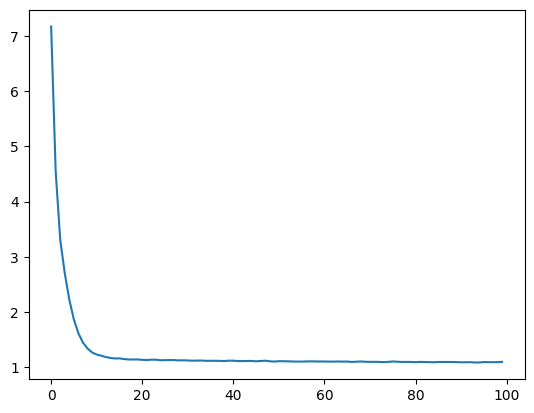

In [65]:
# get out the loss and val loss for the figures. 

# need to average elementwise, from all sets and the different random states, 50 histories --> average to 1 history

arr = np.empty([0,100])
val_arr = np.empty([0,100])

for i in range(10):

    arr = np.vstack([arr, np.mean(loss_dict[i]['loss'], axis=0)])
    #val_arr = np.vstack([val_arr, np.mean(loss[str(i)]['val_loss'], axis=0)])

avg_loss = np.mean(arr, axis=0)
#avg_val_loss = np.mean(val_arr, axis=0)

plt.plot(avg_loss, label='loss')
#plt.plot(avg_val_loss, label='val_loss')

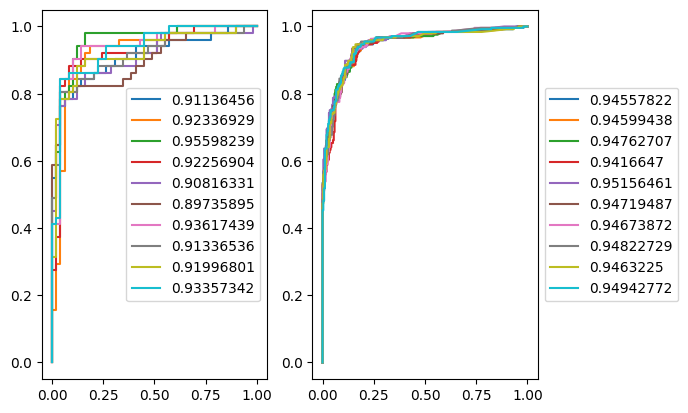

In [92]:
fig, ax = plt.subplots(1,2)

roc_df = pd.DataFrame(roc_dict[3])

auc_split = []

for i,j, x, y in zip(roc_df['test_fpr'], roc_df['test_tpr'], roc_df['train_fpr'], roc_df['train_tpr']):
    ax[0].plot(i,j)
    ax[1].plot(x,y)

ax[0].legend(loc='center right', labels=[0.91136456, 0.92336929, 0.95598239, 0.92256904, 0.90816331, 0.89735895,
 0.93617439, 0.91336536, 0.91996801, 0.93357342])
plt.legend(labels=[0.94557822, 0.94599438, 0.94762707, 0.9416647,  0.95156461, 0.94719487,
 0.94673872, 0.94822729, 0.9463225,  0.94942772], loc='center left', bbox_to_anchor=(1.0, 0.5))


# Graveyard stuff

In [ ]:
def get_model_manual_tuned():
    
    model = keras.Sequential([
        
        keras.layers.InputLayer(input_shape = (59,)),

        keras.layers.Dense(16, activation='elu', kernel_regularizer=regularizers.L1(0.01)),

        keras.layers.Dense(16, activation='elu', kernel_regularizer=regularizers.L1(0.01)),

        keras.layers.Dense(32, activation='elu', kernel_regularizer=regularizers.L1(0.01)),

        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                 optimizer = keras.optimizers.Adam(learning_rate=0.01),
                 metrics=['AUC',
                          mcc_threshold(threshold=0.5),
                          keras.metrics.BinaryAccuracy(threshold=0.5),
                          keras.metrics.Recall(thresholds=0.5),
                          custom_f1_pos,
                          custom_f1_neg])
    
    return model

In [ ]:
# X_train, y_train, X_test, x_test

# splitting into chunks
training_chunk1 = test_set[:100]
training_chunk2 = test_set[100:200]
training_chunk3 = test_set[200:300]
training_chunk4 = test_set[300:]
training_chunk5 = val_set

# create the five different training sets                                                                             # excluded
set1 = pd.concat([training_chunk1,training_chunk2,training_chunk3,training_chunk4]).reset_index(drop=True)            # training_chunk5
set2 = pd.concat([training_chunk1,training_chunk2,training_chunk3,training_chunk5]).reset_index(drop=True)            # training_chunk4
set3 = pd.concat([training_chunk1,training_chunk2,training_chunk4,training_chunk5]).reset_index(drop=True)            # training_chunk3
set4 = pd.concat([training_chunk1,training_chunk3,training_chunk4,training_chunk5]).reset_index(drop=True)            # training_chunk2
set5 = pd.concat([training_chunk2,training_chunk3,training_chunk4,training_chunk5]).reset_index(drop=True)            # training_chunk1